In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import scipy.ndimage as spi
import os
import pandas as pd
from astropy.wcs import WCS
from astropy.visualization import SqrtStretch, imshow_norm, LogStretch, ZScaleInterval
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils import CircularAperture
from astropy.stats import sigma_clipped_stats
from photutils import DAOStarFinder
from astropy.nddata import Cutout2D
from skimage import restoration
import astropy as astro
from astropy.io import fits
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import matplotlib.pylab as pylab
import astropy.units as u

params = {'legend.fontsize': 'x-large',
#           'figure.figsize': (10, 10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
plt.style.use("science")

# from reproject import reproject_interp

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

np.set_printoptions(edgeitems=10)
np.core.arrayprint._line_width = 180
%matplotlib inline

In [2]:
datapath = "../data/RXJ1131-1231_j9ya08010_FILTER_F165LP_NA_EXPTIME2516.0_drz.fits"
datapath2 = "../data/hst_mos_0043768_acs_wfc_f814w_sci.fits"
data = fits.open(datapath)

In [3]:
data.info()

Filename: ../data/RXJ1131-1231_j9ya08010_FILTER_F165LP_NA_EXPTIME2516.0_drz.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     695   ()      
  1  SCI           1 ImageHDU        63   (1392, 1366)   float32   
  2  WHT           1 ImageHDU        46   (1392, 1366)   float32   
  3  CTX           1 ImageHDU        39   (1392, 1366)   int32   
  4  HDRTAB        1 BinTableHDU    631   4R x 311C   [9A, 3A, K, D, D, D, D, D, D, D, D, D, D, D, D, D, K, 3A, 9A, 7A, 18A, D, D, D, D, D, 3A, D, D, D, D, D, D, D, D, D, D, D, D, D, D, 3A, D, D, D, D, K, K, K, D, K, 23A, 9A, 20A, D, D, D, D, D, D, D, D, 3A, D, D, D, D, K, K, 3A, 3A, D, D, D, D, D, D, 3A, D, D, D, D, D, D, D, D, 4A, 12A, 12A, 3A, 4A, 3A, 10A, 10A, D, D, 3A, 3A, 23A, 4A, 8A, 7A, 3A, D, K, D, 6A, 9A, D, D, D, L, 4A, 18A, 3A, K, 6A, 3A, D, D, D, 8A, D, 3A, L, K, L, K, L, K, K, 8A, 12A, D, D, D, D, 3A, 1A, D, 23A, D, D, D, 3A, 23A, L, D, 3A, D, 8A, 3A, 6A, D, L, L, D, D, D, D, D, D, D

In [4]:
data["SCI"].header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 1392                                                  
NAXIS2  =                 1366                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
INHERIT =                    T / inherit the primary header                     
EXTNAME = 'SCI     '           / extension name                                 
EXTVER  =                    1                                                  
BUNIT   = 'ELECTRONS/S'        / Units of science product                       
                                                                                
CD1_1   = 1.89476327001595E-

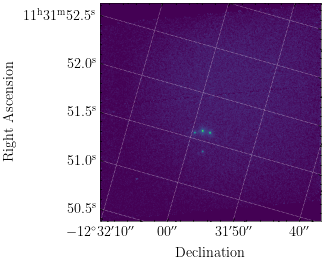

In [5]:
im = data["SCI"].data
im[np.isnan(im)] = 0
safe_log = lambda x: np.log(x + 1e-16)
wcs = WCS(data["SCI"].header)
plt.subplot(projection=wcs)
plt.imshow(im, norm=ImageNormalize(stretch=LogStretch()))
ax = plt.gca()


ax.coords[0].set_ticklabel_position('l')
ax.coords[0].grid(color='white', ls='dotted')
ax.set_ylabel('Right Ascension')
ax.coords[1].set_ticklabel_position('b')
ax.coords[1].grid(color='white', ls='dotted')
ax.set_xlabel('Declination');


# plt.plot(data["SCI"].header["CRPIX1"], data["SCI"].header["CRPIX2"], "ro")
# plt.colorbar()

In [6]:
# get position of images A, B, C and D

mean, median, std = sigma_clipped_stats(im,  sigma=3.0)
print(mean, median, std) # our points of interest

8.152801e-06 0.0 2.2723994e-05


In [7]:
print(200 * std)
print(np.nanmax(im))

0.004544798866845667
0.17308687


In [8]:
daofind = DAOStarFinder(fwhm=6.0, threshold=200.*std)
sources = daofind(im - median)

In [9]:
# help(DAOStarFinder)

In [10]:
for col in sources.colnames:
    sources[col].info.format = '%.8g'
sources

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
1,643.315,435.19137,0.71535613,-0.0099632518,0.23999725,49,0,0.011926432,3.4577077,-1.3469707
2,689.54896,552.37375,0.55170432,-0.24827293,0.19399991,49,0,0.084966384,30.741863,-3.7193255
3,594.16295,553.79224,0.71628677,0.0062130871,0.22676076,49,0,0.043925907,13.47906,-2.824149
4,643.63852,564.16457,0.64106269,-0.07457213,0.24459418,49,0,0.17308687,56.853991,-4.3869024


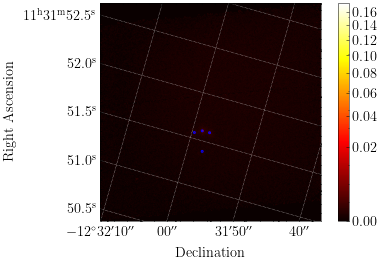

In [11]:
plt.subplot(projection=wcs)
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=6.)
norm = ImageNormalize(stretch=SqrtStretch())
plt.imshow(im, cmap="hot", norm=norm)
ax = plt.gca()
apertures.plot(color='blue', lw=1, alpha=1)
plt.colorbar()
ax.coords[0].set_ticklabel_position('l')
ax.coords[0].grid(color='white', ls='dotted')
ax.set_ylabel('Right Ascension')
ax.coords[1].set_ticklabel_position('b')
ax.coords[1].grid(color='white', ls='dotted')
ax.set_xlabel('Declination');

In [12]:
# help(SqrtStretch)
# help(CircularAperture)

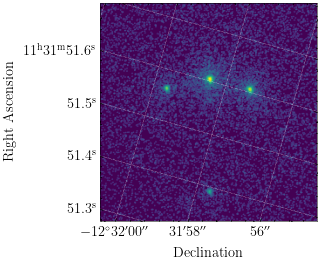

In [13]:

centroid = np.mean(positions, axis=0)
size = (250, 250)
cutout = Cutout2D(im, centroid, size, wcs=wcs)

plt.subplot(projection=cutout.wcs)
plt.imshow(cutout.data, norm=ImageNormalize(stretch=LogStretch()))
ax = plt.gca()
ax.coords[0].set_ticklabel_position('l')
ax.coords[0].grid(color='white', ls='dotted')
ax.set_ylabel('Right Ascension')
ax.coords[1].set_ticklabel_position('b')
ax.coords[1].grid(color='white', ls='dotted')
ax.set_xlabel('Declination');
# plt.plot(centroid[0], centroid[1], "ro")

In [14]:
# sky = world.pixel_to_world(positions[:, 0], positions[:, 1])
# sky

In [15]:
data2 = fits.open(datapath2)
data2.info()

Filename: ../data/hst_mos_0043768_acs_wfc_f814w_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     863   ()      
  1  SCI           1 ImageHDU        82   (7600, 6800)   float32   


In [16]:
im2 = data2["SCI"].data
data2["SCI"].header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 7600                                                  
NAXIS2  =                 6800                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
INHERIT =                    T / inherit the primary header                     
EXTNAME = 'SCI     '           / extension name                                 
EXTVER  =                    1                                                  
BUNIT   = 'ELECTRONS/S'        / Units of science product                       
                                                                                
CD1_1   = -1.1111111111111E-

In [17]:
# data2[0].header

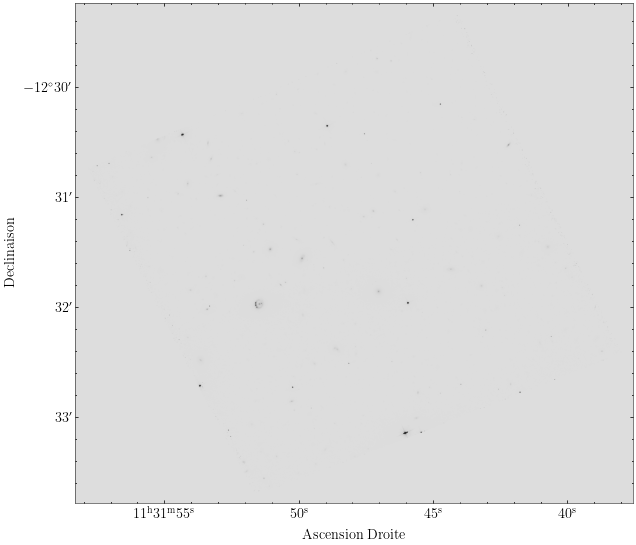

In [18]:
wcs2 = WCS(data2["sci"].header)
plt.figure(figsize=(10, 10))
plt.subplot(projection=wcs2)
plt.imshow(im2, cmap="gray_r", norm=ImageNormalize(interval=ZScaleInterval(), stretch=LogStretch()))

ax = plt.gca()
# ax.coords[0].set_ticklabel_position('l')
# ax.coords[0].grid(color='white', ls='dotted')
ax.set_xlabel('Ascension Droite')
# ax.coords[1].set_ticklabel_position('b')
# ax.coords[1].grid(color='white', ls='dotted')
ax.set_ylabel('Declinaison');

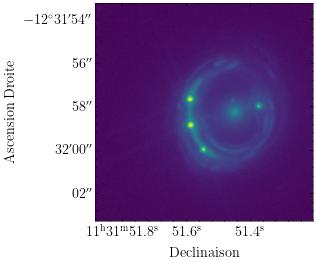

In [19]:
centroid2 = wcs2.world_to_pixel(wcs.pixel_to_world(*list(centroid)))
cutout2 = Cutout2D(im2, centroid2, (250, 250), wcs=wcs2)
plt.subplot(projection=cutout2.wcs)
plt.imshow(cutout2.data, norm=ImageNormalize(stretch=LogStretch()))
ax = plt.gca()
# ax.coords[0].set_ticklabel_position('l')
# ax.coords[0].grid(color='white'|, ls='dotted')
ax.set_ylabel('Ascension Droite')
# ax.coords[1].set_ticklabel_position('b')
# ax.coords[1].grid(color='white', ls='dotted')
ax.set_xlabel('Declinaison');


In [20]:
# data2["SCI"].header

In [21]:
# data2[0].header

In [22]:
mean, median, std = sigma_clipped_stats(cutout2.data,  sigma=3.0)
print(mean, median, std)
daofind = DAOStarFinder(fwhm=6.0, threshold=30.*std)
sources = daofind(cutout2.data)
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
center = 2
apertures = CircularAperture(positions[center], r=6.) # select the right source for center
sources

0.034601282 0.018134186 0.041919198


id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
1,124.0632398739095,81.56894692463571,0.6653726183026735,-0.08443170409473048,0.09472028900105607,49,0.0,50.01344299316406,57.60682936585934,-4.401184931652287
2,109.32193957179857,109.50838262712394,0.5153508265060384,-0.05626704707422013,-0.05654931411506093,49,0.0,109.44438171386719,148.30537765625428,-5.427892247835505
3,160.09602819832483,124.68113231794172,0.41259270772020185,0.19732545040702068,-0.11524817540477009,49,0.0,3.823855400085449,2.747111481772431,-1.097190710197011
4,187.23637926939622,131.42511592700944,0.9369408585019174,0.0627602259714352,0.021265877901839023,49,0.0,17.978187561035156,15.487007959865512,-2.974918803914724
5,108.63206479747741,139.16674332188566,0.6596110185334518,-0.09167446050321759,-0.10330010090185612,49,0.0,123.98076629638672,144.6994472202905,-5.401167180084462


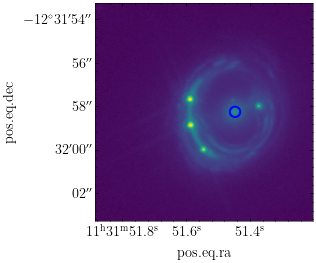

In [23]:
plt.subplot(projection=cutout2.wcs)
plt.imshow(cutout2.data, norm=ImageNormalize(stretch=LogStretch()))
apertures.plot(color='blue', lw=2, alpha=1)


In [24]:
cutout2.data.shape

(250, 250)

In [25]:
# recenter image again
size = 175 * u.pixel
cutout3 = Cutout2D(cutout2.data, positions[center], size, wcs=cutout2.wcs)
position_cutout3 = wcs2.world_to_pixel(cutout2.wcs.pixel_to_world(*list(positions[center])))
x1 = position_cutout3[0] - 100
x2 = position_cutout3[0] + 100
y1 = position_cutout3[1] - 100
y2 = position_cutout3[1] + 100

0.11370624 0.06776108 0.104247645


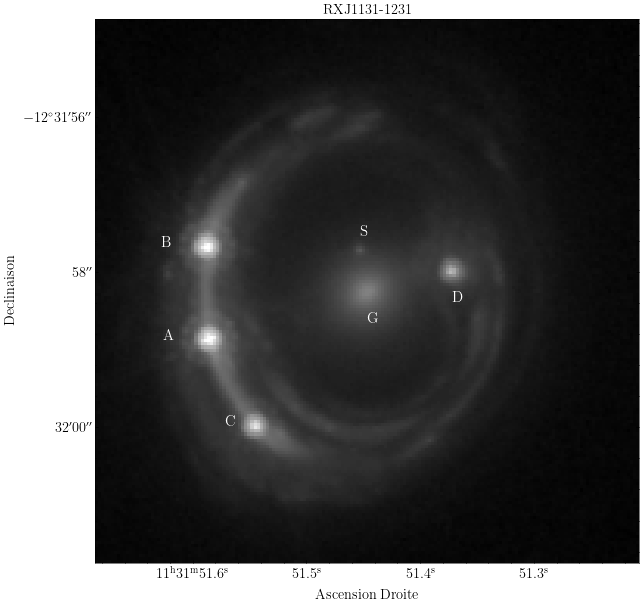

In [26]:
mean, median, std = sigma_clipped_stats(cutout3.data,  sigma=3.0)
print(mean, median, std)
daofind = DAOStarFinder(fwhm=3.0, threshold=5.*std)
sources = daofind(cutout3.data)
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
center = 4
apertures = CircularAperture(positions[center], r=6.) # select the right source for center
plt.figure(figsize=(10, 10))
plt.subplot(projection=cutout3.wcs)
plt.imshow(cutout3.data,cmap="gray", norm=ImageNormalize(stretch=LogStretch()))
ax = plt.gca()
ax.set_xlabel('Ascension Droite')
ax.set_ylabel('Declinaison')

object_positions = sources[[7, 3, 1, 5, 4, 6]]["xcentroid", "ycentroid"].to_pandas().to_numpy() # B, A, C, D, G, S
ox, oy = object_positions[:, 0], object_positions[:, 1]
ax.annotate("A",  [ox[1]-15, oy[1]], color="w", fontsize=15)
ax.annotate("B",  [ox[0]-15, oy[0]], color="w", fontsize=15)
ax.annotate("C",  [ox[2]-10, oy[2]], color="w", fontsize=15)
ax.annotate("D",  [ox[3], oy[3]-10], color="w", fontsize=15)
ax.annotate("G",  [ox[4], oy[4]-10], color="w", fontsize=15)
ax.annotate("S",  [ox[5], oy[5]+5], color="w", fontsize=15)
# apertures.plot(color='blue', lw=2, alpha=1)
# sources.to_pandas().sort_values("flux", ascending=False)
ax.set_title("RXJ1131-1231")
plt.savefig("../latex/beamer_lens/figures/good_cutout.png")
ox, oy = wcs2.world_to_pixel(cutout3.wcs.pixel_to_world(object_positions[:, 0], object_positions[:, 1]))

In [27]:
object_positions

array([[ 35.63010754, 101.14992219],
       [ 36.31652521,  71.48420784],
       [ 51.11519005,  43.54091825],
       [114.24860758,  93.42748217],
       [ 87.01709376,  86.8018762 ],
       [ 84.81858414,  99.86799054]])

In [28]:
cutout3.data.shape

(175, 175)

In [29]:
np.savetxt("../data/images_positions.txt", object_positions)

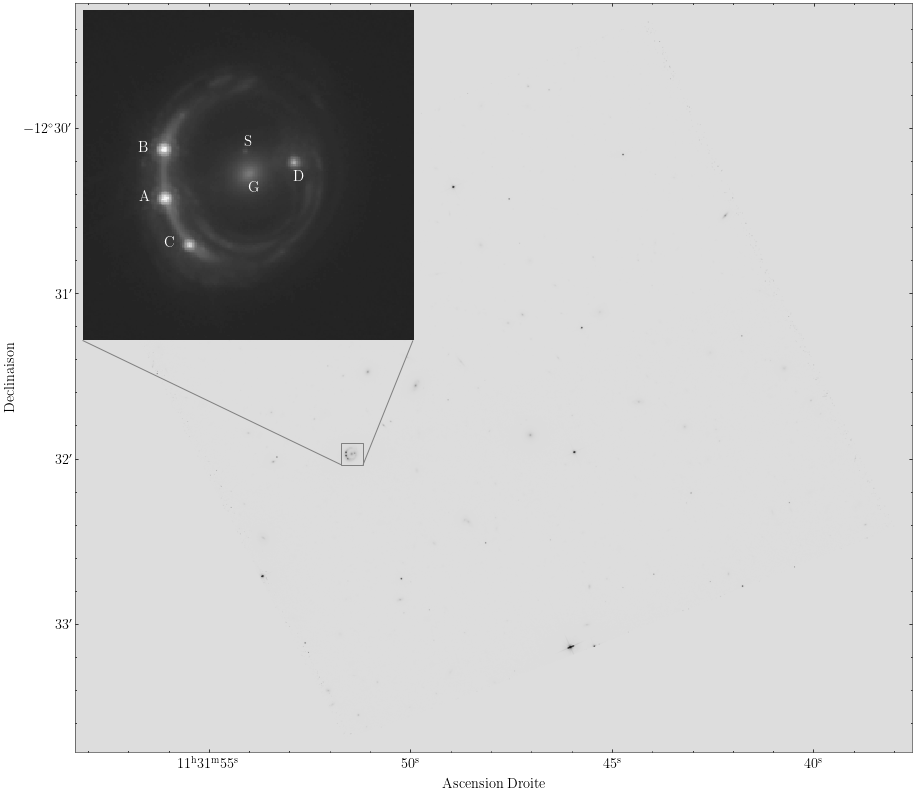

In [30]:
plt.figure(figsize=(15, 15))
plt.subplot(projection=wcs2)
plt.title("")
plt.imshow(im2, cmap="gray_r", norm=ImageNormalize(interval=ZScaleInterval(), stretch=LogStretch()))

ax = plt.gca()
ax.set_xlabel('Ascension Droite')
ax.set_ylabel('Declinaison')
extent=[0, im2.shape[1], 0, im2.shape[0]]
axins = zoomed_inset_axes(ax, 15, loc=2) # zoom = 6
axins.imshow(im2, interpolation="nearest", extent=extent,
             origin="lower", cmap="gray", norm=ImageNormalize(stretch=LogStretch()))
axins.axis("off")
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.annotate("A",  [ox[1]-15, oy[1]], color="w", fontsize=15)
axins.annotate("B",  [ox[0]-15, oy[0]], color="w", fontsize=15)
axins.annotate("C",  [ox[2]-15, oy[2]], color="w", fontsize=15)
axins.annotate("D",  [ox[3], oy[3]-10], color="w", fontsize=15)
axins.annotate("G",  [ox[4], oy[4]-10], color="w", fontsize=15)
axins.annotate("S",  [ox[5], oy[5]+5], color="w", fontsize=15)
mark_inset(ax, axins, loc1=3, loc2=4, fc="none", ec="0.5");
plt.savefig("../latex/beamer_lens/figures/wide_field_and_zoom.png")

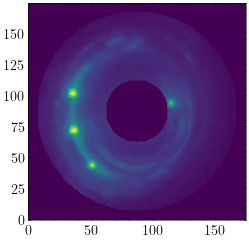

In [31]:
# bad pixel map for galfit
b_map = np.zeros_like(cutout3.data)
# b_map[0:70, :] = 1
# b_map[:, 150:-1] = 1
# b_map[150:-1, :] = 1
N = cutout3.data.shape[1]
x = np.arange(N) - N//2
M = cutout3.data.shape[0]
y = np.arange(M) - M//2
xx, yy = np.meshgrid(x, y)
rho = np.hypot(xx, yy)
b_map += (rho > 25) & (rho < 80)
plt.imshow(cutout3.data * b_map, norm=ImageNormalize(stretch=LogStretch()), origin="lower")
# new_hdul = fits.HDUList()
# new_hdul.append(fits.PrimaryHDU(data=b_map, header=cutout3.wcs.to_header()))
# new_hdul.writeto("../data/rxj1131_bad_pixel_map_galfit.fits")

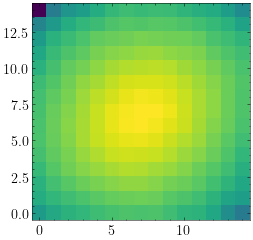

In [32]:
size = (15, 15)
cutout4 = Cutout2D(cutout3.data, positions[center], size, wcs=cutout3.wcs)
plt.imshow(cutout4.data, norm=ImageNormalize(stretch=LogStretch()), origin= "lower")

In [33]:
# new_hdul = fits.HDUList()
# new_hdul.append(fits.PrimaryHDU(data=cutout3.data, header=cutout3.wcs.to_header()))
# new_hdul.writeto("../data/rxj1131_cutout.fits", overwrite=True)

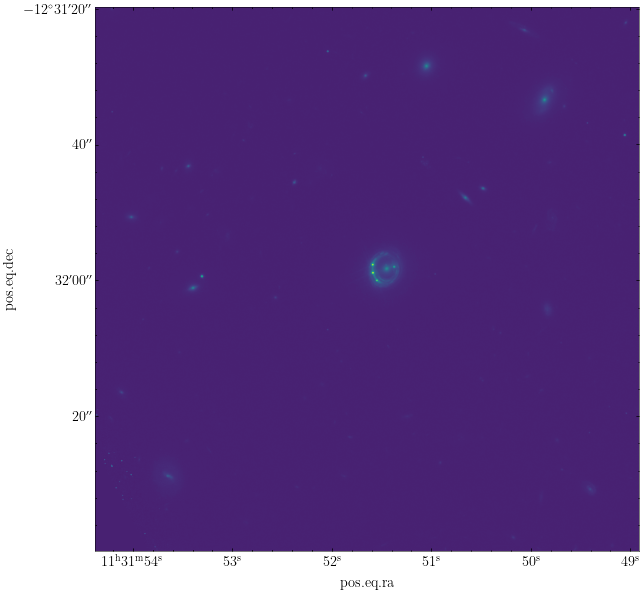

In [34]:
# find star near objective to model the psf
position = wcs2.world_to_pixel(cutout2.wcs.pixel_to_world(*list(positions[center])))
size = (2000, 2000)
psf_cutout = Cutout2D(im2, position, size, wcs=wcs2)
plt.figure(figsize=(10, 10))
plt.subplot(projection=psf_cutout.wcs)
plt.imshow(psf_cutout.data, norm=ImageNormalize(stretch=LogStretch()))

0.0015246872 0.0013210722 0.00534972


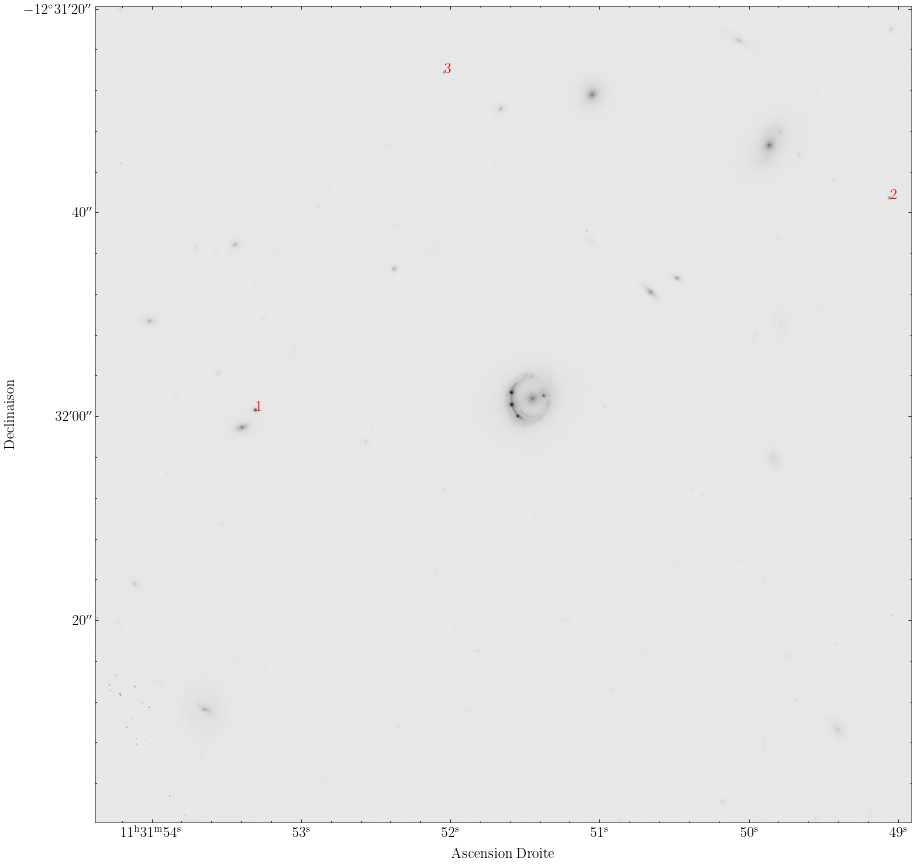

In [44]:
mean, median, std = sigma_clipped_stats(psf_cutout.data,  sigma=3.0)
print(mean, median, std)
daofind = DAOStarFinder(fwhm=5.0, threshold=100.*std)
sources = daofind(psf_cutout.data)
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
candidate1 = 9 # candidate for psf estimate
candidate2 = 22
candidate3 = 28
apertures = CircularAperture(positions[(candidate1, candidate2, candidate3), :], r=4.) # select the right source for center
plt.figure(figsize=(15, 15))
plt.subplot(projection=psf_cutout.wcs)
plt.imshow(psf_cutout.data, norm=ImageNormalize(stretch=LogStretch()), cmap="gray_r")
plt.annotate("  1", positions[candidate1], color="red", fontsize=15)
plt.annotate("  2", positions[candidate2], color="red", fontsize=15)
plt.annotate("  3", positions[candidate3], color="red", fontsize=15)
ax = plt.gca()
ax.set_xlabel('Ascension Droite')
ax.set_ylabel('Declinaison')
# apertures.plot(color='red', lw=1.5, alpha=1)

In [45]:
# sources

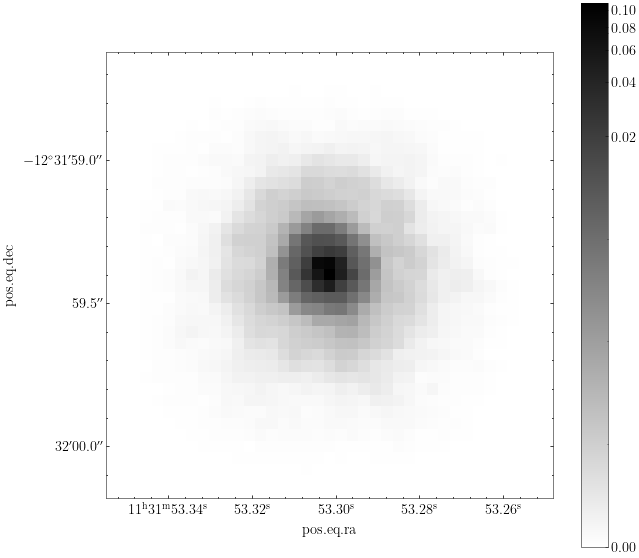

In [119]:
size = (39, 39) # keep this number odd please
psf1_cutout = Cutout2D(psf_cutout.data, positions[candidate1], size, wcs=psf_cutout.wcs)
psf1 = psf1_cutout.data.copy()
from scipy.signal.windows import hann
# gaus = gaussian(39, 100)
# gaus = np.outer(gaus, gaus)
han = hann(39)
han = np.outer(han, han)
# psf1 *= gaus
psf1 *= han
psf1 /= psf1.sum()
plt.figure(figsize=(10, 10))
plt.subplot(projection=psf1_cutout.wcs)
plt.imshow(psf1, norm=ImageNormalize(stretch=LogStretch()), cmap="gray_r")
plt.colorbar()
# plt.matshow(np.log10(psf1))

In [117]:
# new_hdul = fits.HDUList()
# new_hdul.append(fits.PrimaryHDU(data=psf1, header=psf1_cutout.wcs.to_header()))
# new_hdul.writeto("../data/rxj1131_psf1.fits", overwrite=True)

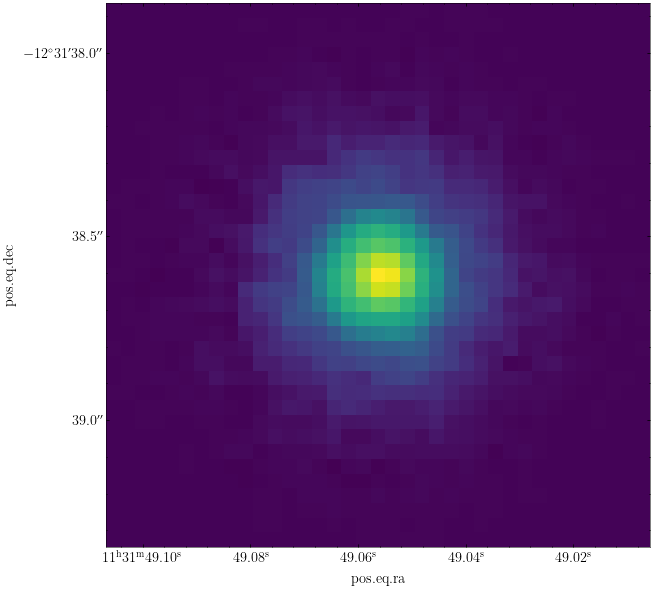

In [83]:
size = (37, 37)
psf2_cutout = Cutout2D(psf_cutout.data, positions[candidate2], size, wcs=psf_cutout.wcs)
psf2 = psf2_cutout.data.copy()
gaus = gaussian(37, 6)
gaus = np.outer(gaus, gaus)
psf2 *= gaus
psf2 /= psf2.sum()
plt.figure(figsize=(10, 10))
plt.subplot(projection=psf2_cutout.wcs)
plt.imshow(psf2, norm=ImageNormalize(stretch=LogStretch()))

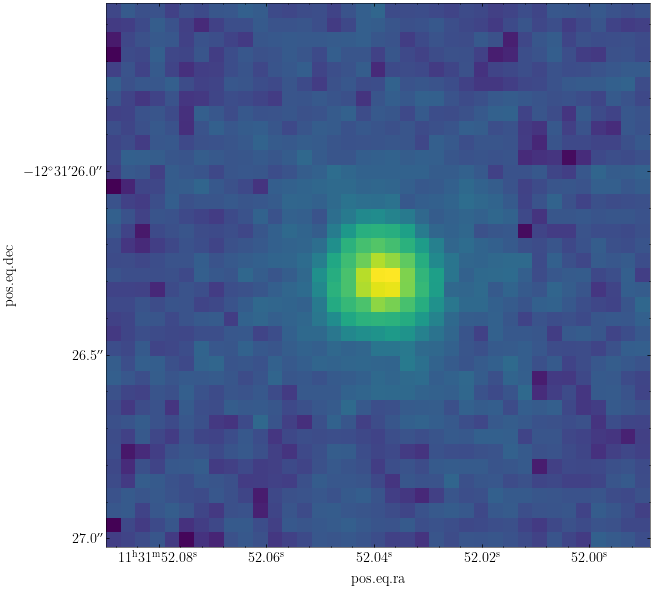

In [84]:
size = (37, 37)
psf3_cutout = Cutout2D(psf_cutout.data, positions[candidate3], size, wcs=psf_cutout.wcs)
plt.figure(figsize=(10, 10))
plt.subplot(projection=psf3_cutout.wcs)
plt.imshow(psf3_cutout.data, norm=ImageNormalize(stretch=LogStretch()))
psf3 = psf3_cutout.data.copy()
psf3 /= psf3.sum() # normalize

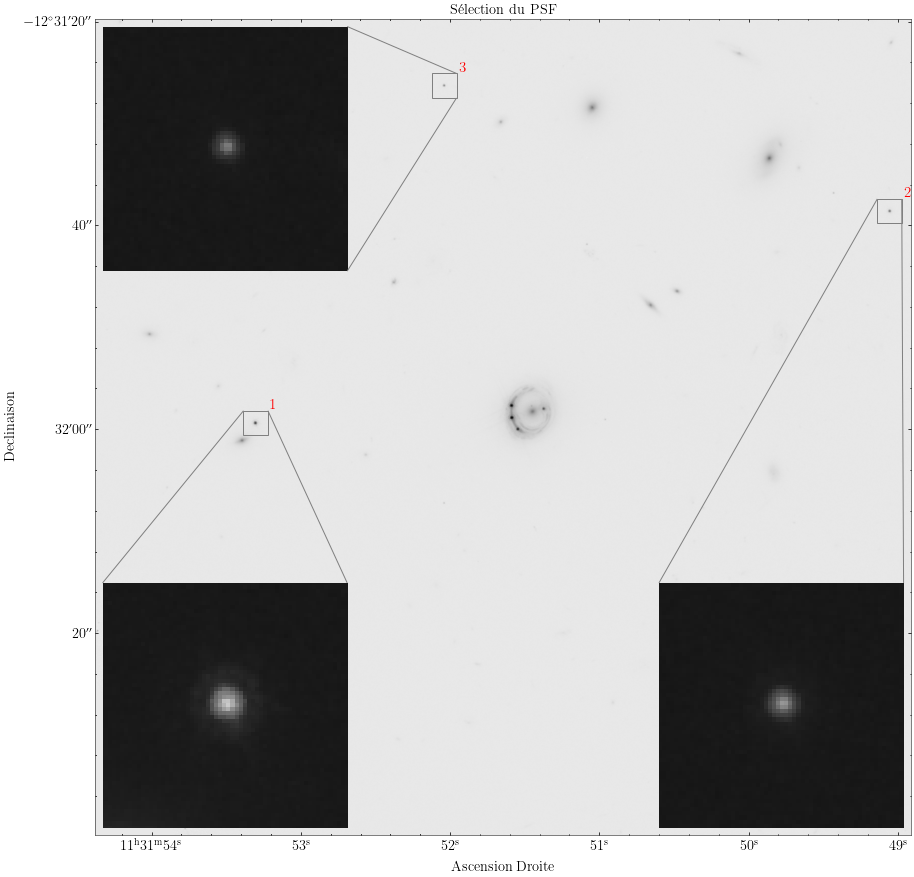

In [75]:
fig = plt.figure(figsize=(15, 15))
plt.subplot(projection=psf_cutout.wcs)
plt.imshow(psf_cutout.data, norm=ImageNormalize(stretch=LogStretch()), cmap="gray_r")
plt.annotate("1", positions[candidate1] + 35, color="red", fontsize=15)
plt.annotate("   2", positions[candidate2] + 35, color="red", fontsize=15)
plt.annotate("    3", positions[candidate3] + 35, color="red", fontsize=15)
ax = plt.gca()

ax = plt.gca()
ax.set_xlabel('Ascension Droite')
ax.set_ylabel('Declinaison')
extent=[0, psf_cutout.data.shape[1], 0, psf_cutout.data.shape[0]]
axins = zoomed_inset_axes(ax, 10, loc=3) # zoom = 6
axins.imshow(psf_cutout.data, interpolation="nearest", extent=extent,
             origin="lower", cmap="gray", norm=ImageNormalize(stretch=LogStretch()))
axins.axis("off")
x1 = positions[candidate1][0] - 30
x2 = positions[candidate1][0] + 30
y1 = positions[candidate1][1] - 30
y2 = positions[candidate1][1] + 30
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
mark_inset(ax, axins, loc1=1, loc2=2, fc="none", ec="0.5");

axins2 = zoomed_inset_axes(ax, 10, loc=4) # zoom = 6
axins2.imshow(psf_cutout.data, interpolation="nearest", extent=extent,
             origin="lower", cmap="gray", norm=ImageNormalize(stretch=LogStretch()))
axins2.axis("off")
x1 = positions[candidate2][0] - 30
x2 = positions[candidate2][0] + 30
y1 = positions[candidate2][1] - 30
y2 = positions[candidate2][1] + 30
axins2.set_xlim(x1, x2)
axins2.set_ylim(y1, y2)
mark_inset(ax, axins2, loc1=1, loc2=2, fc="none", ec="0.5");

axins3 = zoomed_inset_axes(ax, 10, loc=2) # zoom = 6
axins3.imshow(psf_cutout.data, interpolation="nearest", extent=extent,
             origin="lower", cmap="gray", norm=ImageNormalize(stretch=LogStretch()))
axins3.axis("off")
x1 = positions[candidate3][0] - 30
x2 = positions[candidate3][0] + 30
y1 = positions[candidate3][1] - 30
y2 = positions[candidate3][1] + 30
axins3.set_xlim(x1, x2)
axins3.set_ylim(y1, y2)
mark_inset(ax, axins3, loc1=1, loc2=4, fc="none", ec="0.5");

ax.set_xlabel('Ascension Droite')
ax.set_ylabel('Declinaison')
ax.set_title("Sélection du PSF")
# fig.suptitle("Sélection du PSF")
plt.savefig("../latex/beamer_lens/figures/psf_cutout.png")